<a href="https://colab.research.google.com/github/chanhvo223/captchaWithTrOCR/blob/main/Reg_Captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install -q transformers
!pip install -q transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.0 MB/s eta 0:00:00


#LOAD DATASET

In [ ]:
import os

import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [ ]:
train_path = "/content/drive/MyDrive/capcha/train/"
train_dir_list = os.listdir(train_path)
train_dataset = pd.DataFrame(train_dir_list, columns=['file_name'])
train_dataset["text"] = train_dataset["file_name"].map(lambda x: x.split(".")[0])
train_dataset.head()

,file_name,text
0,7y2x4.png,7y2x4
1,6mygb.png,6mygb
2,dmw8n.png,dmw8n
3,3ebpw.png,3ebpw
4,7b4bm.png,7b4bm


In [ ]:
# val_path = "outputs/val/"
# val_dir_list = os.listdir(val_path)
# val_dataset = pd.DataFrame(val_dir_list, columns=['file_name'])
# val_dataset["text"] = val_dataset["file_name"].map(lambda x: x.split(".")[0])
# val_dataset.head()

In [ ]:
test_path = "/content/drive/MyDrive/capcha/test/"
test_dir_list = os.listdir(test_path)
test_dataset = pd.DataFrame(test_dir_list, columns=['file_name'])
test_dataset["text"] = test_dataset["file_name"].map(lambda x: x.split(".")[0])
test_dataset.head()

,file_name,text
0,244e2.png,244e2
1,2g7nm.png,2g7nm
2,cpe63.png,cpe63
3,2b827.png,2b827
4,2cgyx.png,2cgyx


#CREATE DATA CLASS

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CaptchaDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # print(pixel_values, type(pixel_values), dir(pixel_values))
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": torch.squeeze(pixel_values), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
MODEL_CKPT = "microsoft/trocr-base-printed"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "_captcha_ocr"
NUM_OF_EPOCHS = 10

#Instantiate Processor, Create Training, & Testing Dataset Instances

In [ ]:
processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)
train_ds = CaptchaDataset(root_dir=train_path,
                          df=train_dataset,
                          processor=processor)

# val_ds = CaptchaDataset(root_dir=val_path,
#                         df=val_dataset,
#                         processor=processor)

test_ds = CaptchaDataset(root_dir=test_path,
                         df=test_dataset,
                         processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
print(f"The training dataset has {len(train_ds)} samples in it.")
# print(f"The testing dataset has {len(val_ds)} samples in it.")
print(f"The training dataset has {len(test_ds)} samples in it.")

The training dataset has 790 samples in it.
The training dataset has 280 samples in it.


#Example of input Data Shapes

In [ ]:
encoding = train_ds[10]

for k, v in encoding.items():
    print(k, " : ", v.shape)

pixel_values  :  torch.Size([3, 384, 384])
labels  :  torch.Size([128])


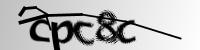

In [ ]:
image = Image.open(train_ds.root_dir + train_dataset["file_name"][10]).convert("RGB")
image

In [ ]:
labels = encoding["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

cpc8c


In [ ]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from datasets import load_metric
cer_metric = load_metric("cer")

<ipython-input-16-6424484073b5>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# training_args = Seq2SeqTrainingArguments(
#     fp16=False,
#     output_dir="./",
#     predict_with_generate=True,
#     evaluation_strategy="steps",
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     logging_steps=2,
#     save_steps=1000,
#     eval_steps=200,
#     save_total_limit=2,
#     remove_unused_columns=False,
#     push_to_hub=False,
#     report_to="tensorboard",
#     load_best_model_at_end=True,
# )

training_args = Seq2SeqTrainingArguments(
    fp16=True,
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_first_step=True,
    push_to_hub=False,
    hub_private_repo=False
)

In [ ]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


**Lúc đầu**

In [ ]:
trainer.train()

**Re-train**

In [ ]:
trainer.train("/content/Trainedmodel2")

There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


Epoch,Training Loss,Validation Loss,Cer
1,0.000100,0.583241,0.075714
2,0.000100,0.585839,0.096429
3,0.000100,0.435120,0.055000
4,0.000100,0.623897,0.080000
5,0.000100,0.439555,0.034286
6,0.149600,0.416137,0.032143
7,0.149600,0.377831,0.027143
8,0.149600,0.402661,0.028571
9,0.149600,0.383891,0.024286
10,0.149600,0.378949,0.023571


TrainOutput(global_step=990, training_loss=0.07825598160253698, metrics={'train_runtime': 1850.778, 'train_samples_per_second': 4.268, 'train_steps_per_second': 0.535, 'total_flos': 5.911453008868147e+18, 'train_loss': 0.07825598160253698, 'epoch': 10.0})

In [ ]:
trainer.save_model("reg-captcha-TrOCR")
trainer.save_state()

In [ ]:
trainer.train("/content/Trainedmodel1")

There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


Epoch,Training Loss,Validation Loss,Cer
1,0.000300,0.520134,0.071429
2,0.000300,0.428714,0.069286
3,0.000300,0.582055,0.080000
4,0.000300,0.269309,0.020000
5,0.000300,0.263345,0.017857


TrainOutput(global_step=495, training_loss=0.11710170054240293, metrics={'train_runtime': 859.063, 'train_samples_per_second': 4.598, 'train_steps_per_second': 0.576, 'total_flos': 2.9557265044340736e+18, 'train_loss': 0.11710170054240293, 'epoch': 5.0})

In [ ]:
metrics = trainer.evaluate(val_ds)
trainer.log_metrics("val_ds", metrics)
trainer.save_metrics("val_ds", metrics)

***** test metrics *****
  epoch                   =        5.0
  eval_cer                =     0.0114
  eval_loss               =     0.1703
  eval_runtime            = 0:00:46.87
  eval_samples_per_second =      5.973
  eval_steps_per_second   =      0.747


#GRADIO DEMO

In [ ]:
!pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1

In [ ]:
!pip install -q typing-extensions==4.5.0 kaleido accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/reg-captcha-TrOCR")

# load image examples from the IAM database
# urls = ['https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSoolxi9yWGAT5SLZShv8vVd0bz47UWRzQC19fDTeE8GmGv_Rn-PCF1pP1rrUx8kOjA4gg&usqp=CAU',
#         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRNYtTuSBpZPV_nkBYPMFwVVD9asZOPgHww4epu9EqWgDmXW--sE2o8og40ZfDGo87j5w&usqp=CAU']
# for idx, url in enumerate(urls):
#   image = Image.open(requests.get(url, stream=True).raw)
#   image.save(f"image_{idx}.png")

def process_image(image):
    # prepare image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # generate (no beam search)
    generated_ids = model.generate(pixel_values)

    # decode
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

title = "Interactive demo: TrOCR"
description = "Demo for Microsoft's TrOCR, an encoder-decoder model consisting of an image Transformer encoder and a text Transformer decoder for state-of-the-art optical character recognition (OCR) on single-text line images. This particular model is fine-tuned on IAM, a dataset of annotated handwritten images. To use it, simply upload an image or use the example image below and click 'submit'. Results will show up in a few seconds."
article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2109.10282'>TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models</a> | <a href='https://github.com/microsoft/unilm/tree/master/trocr'>Github Repo</a></p>"
# examples =[["image_0.png"], ["image_1.png"], ["image_2.png"]]

iface = gr.Interface(fn=process_image,
                     inputs=gr.inputs.Image(type="pil"),
                     outputs="text",
                     title=title,
                     description=description,
                     article=article,
                    #  examples=examples
                     )
iface.launch(debug=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
<ipython-input-45-1d6908e83ac3>:34: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Image(type="pil"),
<ipython-input-45-1d6908e83ac3>:34: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Image(type="pil"),


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://43ac61500ad97816ab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#HUNGGING FACE

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-to-text",
    "tags": ["image-to-text"],
}

trainer.push_to_hub('🍻 cheers', **kwargs)

In [ ]:
!zip -r runs.zip /content/trocr-base-printed_captcha_ocr/runs
from google.colab import files
files.download("runs.zip")